In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import numpy as np
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.plotsettings import *

%matplotlib inline

In [3]:
molclr = pd.read_csv("../../03_classification/molclr_regression_res.csv")
molclr_grouped = (
    molclr[molclr["name"] == "FreeSolv"].groupby(["num_size"]).agg(["mean", "std", sem])
)

/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ipykernel_55737/446663461.py:3: FutureWarning: ['name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  molclr[molclr["name"] == "FreeSolv"].groupby(["num_size"]).agg(["mean", "std", sem])


In [4]:
all_res = glob("out/**/*.pkl")

In [5]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded["representation"]
    num_points = loaded["num_train_points"]

    metrics = {
        "representation": loaded["representation"],
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["gpr_baseline"]["mean_absolute_error"],
        "max_error": loaded["gpr_baseline"]["max_error"],
        "mse": loaded["gpr_baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [6]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [7]:
compiled_grouped_res = compiled_res.groupby(["representation", "num_train_points"]).agg(
    ["mean", "std", sem]
)

In [8]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std", sem])

In [9]:
compiled_grouped_res

mae                      max_error  \
                                     mean       std       sem       mean   
representation num_train_points                                            
smiles         10                3.475614  0.312447  0.104149  20.153333   
               20                3.257690  0.351225  0.124177  22.490000   
               50                2.594349  0.138203  0.052236  19.887143   
               100               2.278264  0.439438  0.196522  15.078000   
               200               1.427512  0.068145  0.030475  10.250000   

                                                           mse            \
                                      std       sem       mean       std   
representation num_train_points                                            
smiles         10                4.246192  1.415397  20.395465  3.386485   
               20                4.162798  1.471771  19.121533  3.835100   
               50                1.539012  0.581692  13.043110  0.863987   
               100               4.763745  2.130412  10.327211  3.598889   
               200               3.017441  1.349441   4.500120  0.324428   

                                           
                                      sem  
representation num_train_points            
smiles         10                1.128828  
               20                1.355913  
               50                0.326556  
               100               1.609472  
               200               0.145089

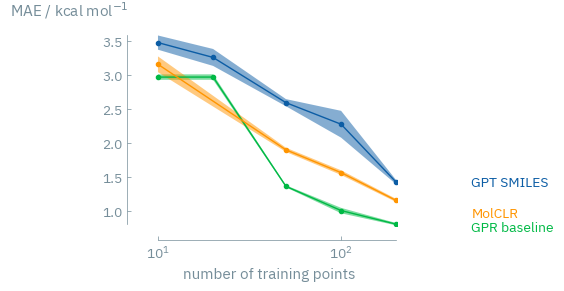

In [10]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1)
# ax.plot(
#     compiled_grouped_res.loc["SELFIES", :].index,
#     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'],
#     label='GPT SELFIES',
#     marker='o'
# )

# ax.fill_between(
#     compiled_grouped_res.loc["SELFIES", :].index,
#     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'] - compiled_grouped_res.loc["SELFIES", :]['mae']['std'],
#     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'] + compiled_grouped_res.loc["SELFIES", :]['mae']['std'],
# )

ax.plot(
    compiled_grouped_res.loc["smiles", :].index,
    compiled_grouped_res.loc["smiles", :]["mae"]["mean"],
    label="GPT SMILES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["smiles", :].index,
    compiled_grouped_res.loc["smiles", :]["mae"]["mean"]
    - compiled_grouped_res.loc["smiles", :]["mae"]["sem"],
    compiled_grouped_res.loc["smiles", :]["mae"]["mean"]
    + compiled_grouped_res.loc["smiles", :]["mae"]["sem"],
    alpha=0.5,
)

ax.plot(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped["mae"]["mean"],
    label="GPR baseline",
    marker="o",
)

ax.fill_between(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["sem"],
    compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["sem"],
    alpha=0.5,
)

ax.plot(
    molclr_grouped.loc[:].index,
    molclr_grouped.loc[:]["mae"]["mean"],
    label="MolCLR",
    marker="o",
)

ax.fill_between(
    molclr_grouped.loc[:].index,
    molclr_grouped.loc[:]["mae"]["mean"] - molclr_grouped.loc[:]["mae"]["sem"],
    molclr_grouped.loc[:]["mae"]["mean"] + molclr_grouped.loc[:]["mae"]["sem"],
    alpha=0.5,
)


matplotx.line_labels()

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top("MAE / kcal mol$^{-1}$", x_pad=0.03, y_pad=0.0)
ax.set_xscale("log")

range_frame(
    ax,
    compiled_gpr_grouped.loc[:].index,
    np.stack(
        [
            compiled_gpr_grouped.loc[:]["mae"]["mean"],
            compiled_grouped_res.loc["smiles", :]["mae"]["mean"]
            + compiled_grouped_res.loc["smiles", :]["mae"]["sem"],
        ]
    ).flatten(),
    pad=0.01,
)
fig.savefig("freesolv_regression_res.pdf", bbox_inches="tight")